In [58]:
"""
Run this file first to observe logging outputs instead of using print() statements.
"""
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from logs import *

In [59]:
logging.basicConfig
logger = logging.getLogger("MAB Application")

In [60]:
np.random.seed(7)

In [61]:

class Bandit(ABC):
    """
    Abstract base class for implementing different bandit algorithms.
    Each subclass must implement the methods defined here.
    """
    @abstractmethod
    def __init__(self, p):
        """
        Initializes the bandit with a probability of success p.
        Args:
            p (float): The probability of the bandit arm returning a reward of 1.
        """
        pass

    @abstractmethod
    def __repr__(self):
        """
        Returns a string representation of the bandit.
        """
        pass

    @abstractmethod
    def pull(self):
        """
        Simulates pulling the bandit arm.
        Returns:
            int: The reward received after pulling the arm.
        """
        pass

    @abstractmethod
    def update(self, reward):
        """
        Updates the bandit's internal state after a pull.
        Args:
            reward (int): The reward received from the last pull.
        """
        pass

    @abstractmethod
    def experiment(self, num_trials):
        """
        Conducts an experiment on the bandit over a specified number of trials.
        Args:
            num_trials (int): The number of trials to run the experiment.
        """
        pass

    @abstractmethod
    def report(self):
        """
        Generates a report on the performance of the bandit.
        Stores results in a CSV file and logs average reward and regret.
        """
        pass

In [62]:
class EpsilonGreedy(Bandit):
    def __init__(self, p):
        self.p = p
        self.epsilon = 1.0
        self.choices = []
        self.rewards = []
        self.estimates = np.zeros_like(p)

    def __repr__(self):
        return f"EpsilonGreedy(p={self.p})"

    def pull(self):
        if np.random.rand() < self.epsilon:
            choice = np.random.randint(len(self.p))
        else:
            choice = np.argmax(self.estimates)
        reward = np.random.rand() < self.p[choice]
        self.update(choice, reward)
        return reward

    def update(self, choice, reward):
        self.choices.append(choice)
        self.rewards.append(reward)
        self.N = self.choices.count(choice)
        self.estimates[choice] += (reward - self.estimates[choice]) / self.N

    def experiment(self, num_trials):
        for t in range(1, num_trials + 1):
            self.epsilon = 1 / np.sqrt(t)
            self.pull()

    def report(self):
        cumulative_reward = sum(self.rewards)
        optimal_reward = max(self.p) * len(self.rewards)
        cumulative_regret = optimal_reward - cumulative_reward
        logging.info(f"{self}: Cumulative Reward: {cumulative_reward}, Cumulative Regret: {cumulative_regret}")
        df = pd.DataFrame({'Bandit': self.choices, 'Reward': self.rewards, 'Algorithm': 'EpsilonGreedy'})
        df.to_csv('epsilon_greedy_rewards.csv', index=False)
        print(f"Cumulative Reward for EpsilonGreedy: {cumulative_reward}")
        print(f"Cumulative Regret for EpsilonGreedy: {cumulative_regret}")

class ThompsonSampling(Bandit):
    def __init__(self, p):
        self.p = p
        self.alpha = np.ones_like(p)
        self.beta = np.ones_like(p)
        self.choices = []
        self.rewards = []

    def __repr__(self):
        return f"ThompsonSampling(p={self.p})"

    def pull(self):
        samples = np.random.beta(self.alpha, self.beta)
        choice = np.argmax(samples)
        reward = np.random.rand() < self.p[choice]
        self.update(choice, reward)
        return reward

    def update(self, choice, reward):
        self.choices.append(choice)
        self.rewards.append(reward)
        self.alpha[choice] += reward
        self.beta[choice] += 1 - reward

    def experiment(self, num_trials):
        for _ in range(num_trials):
            self.pull()

    def report(self):
        cumulative_reward = sum(self.rewards)
        optimal_reward = max(self.p) * len(self.rewards)
        cumulative_regret = optimal_reward - cumulative_reward
        logging.info(f"{self}: Cumulative Reward: {cumulative_reward}, Cumulative Regret: {cumulative_regret}")
        df = pd.DataFrame({'Bandit': self.choices, 'Reward': self.rewards, 'Algorithm': 'ThompsonSampling'})
        df.to_csv('thompson_sampling_rewards.csv', index=False)
        print(f"Cumulative Reward for ThompsonSampling: {cumulative_reward}")
        print(f"Cumulative Regret for ThompsonSampling: {cumulative_regret}")

In [63]:
class Visualization():
    def plot1(self, bandit, color=None):
        """
        Visualize the learning process (average rewards) of a bandit on linear and logarithmic scales.
        Args:
            bandit (Bandit): An instance of the bandit after running the experiment.
            color (str): Color of the plot lines.
        """
        average_rewards = np.cumsum(bandit.rewards) / np.arange(1, len(bandit.rewards) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        ax1.plot(average_rewards, label=f'{str(bandit)} Learning Process', color=color)
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Average Reward')
        ax1.set_title('Learning Process of Bandit (Linear Scale)')
        ax1.legend()

        ax2.semilogx(average_rewards, label=f'{str(bandit)} Learning Process', color=color)
        ax2.set_xlabel('Trials')
        ax2.set_ylabel('Average Reward')
        ax2.set_title('Learning Process of Bandit (Logarithmic Scale)')
        ax2.legend()

        plt.suptitle('Learning Process of Bandit')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing to prevent clipping of titles
        plt.show()

    def plot2(self, bandit, color=None):
        """
        Compare cumulative rewards and regrets of a provided bandit.
        Args:
            bandit (Bandit): An instance of the bandit after running the experiment.
            color (str): Color of the plot lines.
        """
        cumulative_rewards = np.cumsum(bandit.rewards)
        optimal_reward = max(bandit.p) * len(bandit.rewards)
        cumulative_regrets = optimal_reward - cumulative_rewards

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        ax1.plot(cumulative_rewards, label=f'{str(bandit)} Cumulative Reward', color=color)
        ax1.set_xlabel('Trials')
        ax1.set_ylabel('Cumulative Reward')
        ax1.set_title('Cumulative Rewards of Bandit')
        ax1.legend()

        ax2.plot(cumulative_regrets, label=f'{str(bandit)} Cumulative Regret', color=color)
        ax2.set_xlabel('Trials')
        ax2.set_ylabel('Cumulative Regret')
        ax2.set_title('Cumulative Regrets of Bandit')
        ax2.legend()

        plt.suptitle('Cumulative Metrics of Bandit')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust spacing to prevent clipping of titles
        plt.show()

# Usage example, specifying different colors for the two sets of plots:
# viz = Visualization()
# viz.plot1(eg_bandit, color='blue')
# viz.plot2(eg_bandit, color='blue')

In [64]:
def comparison(epsilon_greedy_bandit, thompson_sampling_bandit):
    # Ensure experiments have been run
    assert len(epsilon_greedy_bandit.rewards) == len(thompson_sampling_bandit.rewards), \
        "Both algorithms must be run for the same number of trials."

    # Calculate cumulative rewards
    eg_cumulative_rewards = np.cumsum(epsilon_greedy_bandit.rewards)
    ts_cumulative_rewards = np.cumsum(thompson_sampling_bandit.rewards)
    
    # Calculate cumulative regrets
    eg_cumulative_regrets = np.cumsum([1 - r for r in epsilon_greedy_bandit.rewards])
    ts_cumulative_regrets = np.cumsum([1 - r for r in thompson_sampling_bandit.rewards])

    # Calculate average rewards (learning process)
    eg_average_rewards = np.cumsum(epsilon_greedy_bandit.rewards) / np.arange(1, len(epsilon_greedy_bandit.rewards) + 1)
    ts_average_rewards = np.cumsum(thompson_sampling_bandit.rewards) / np.arange(1, len(thompson_sampling_bandit.rewards) + 1)

    # Plot learning process (average rewards)
    plt.figure(figsize=(14, 7))
    plt.plot(eg_average_rewards, label='Epsilon Greedy Learning Process')
    plt.plot(ts_average_rewards, label='Thompson Sampling Learning Process')
    plt.xlabel('Trials')
    plt.ylabel('Average Reward')
    plt.title('Comparison of Learning Process')
    plt.legend()
    plt.show()

    # Plot cumulative rewards
    plt.figure(figsize=(14, 7))
    plt.plot(eg_cumulative_rewards, label='Epsilon Greedy Cumulative Reward')
    plt.plot(ts_cumulative_rewards, label='Thompson Sampling Cumulative Reward')
    plt.xlabel('Trials')
    plt.ylabel('Cumulative Reward')
    plt.title('Comparison of Cumulative Rewards')
    plt.legend()
    plt.show()

    # Plot cumulative regrets
    plt.figure(figsize=(14, 7))
    plt.plot(eg_cumulative_regrets, label='Epsilon Greedy Cumulative Regret')
    plt.plot(ts_cumulative_regrets, label='Thompson Sampling Cumulative Regret')
    plt.xlabel('Trials')
    plt.ylabel('Cumulative Regret')
    plt.title('Comparison of Cumulative Regrets')
    plt.legend()
    plt.show()

# This function should be called after running experiments for both bandits, like so:
# comparison(epsilon_greedy_instance, thompson_sampling_instance)


Epsilon Greedy Results:


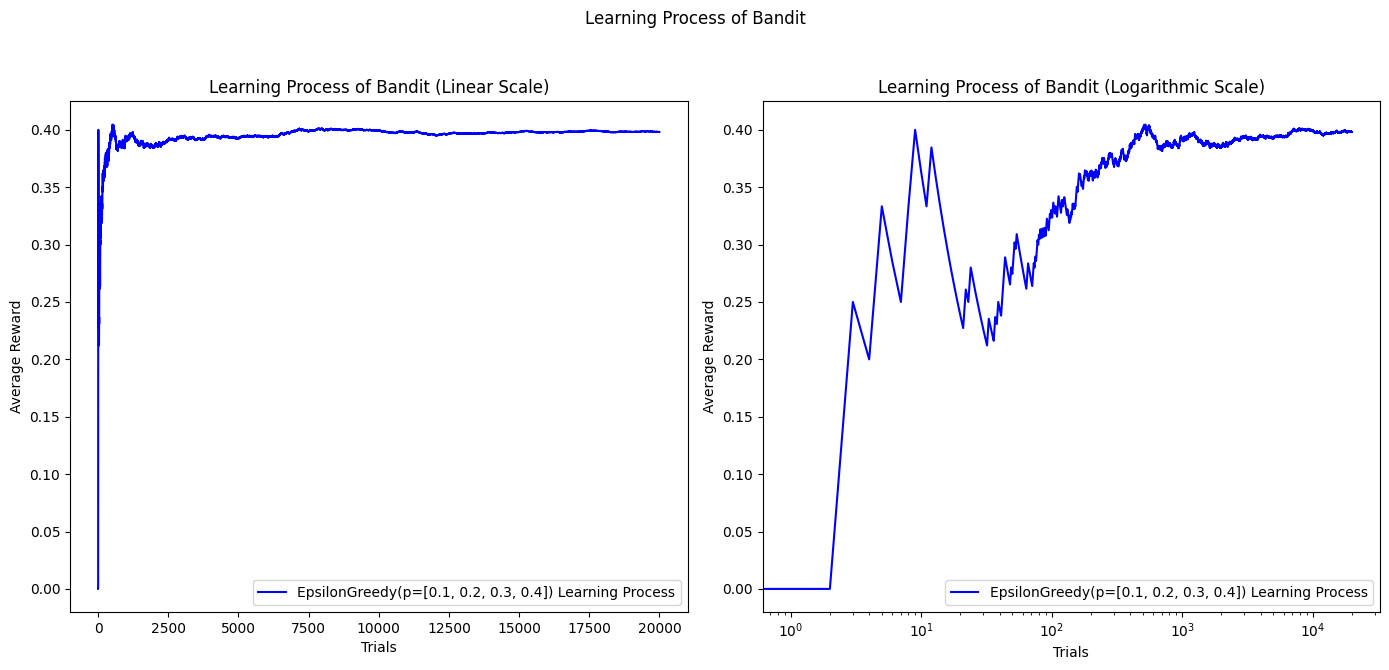

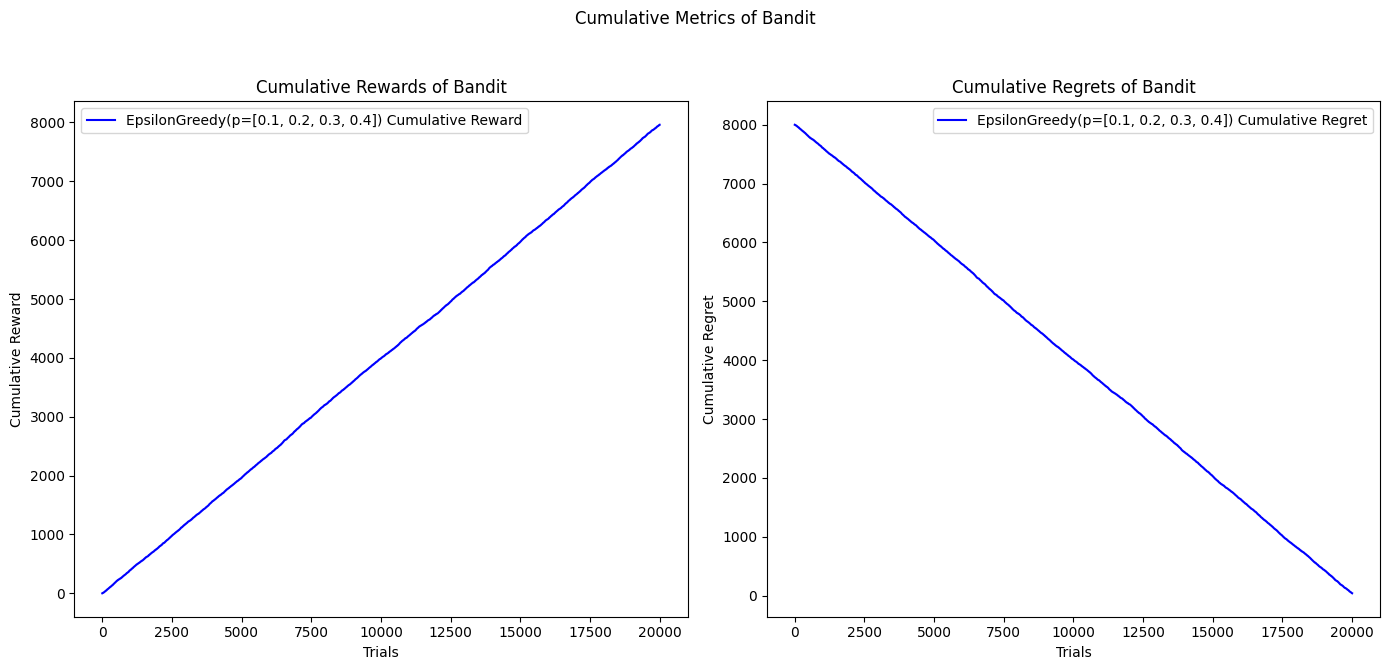

Thompson Sampling Results:


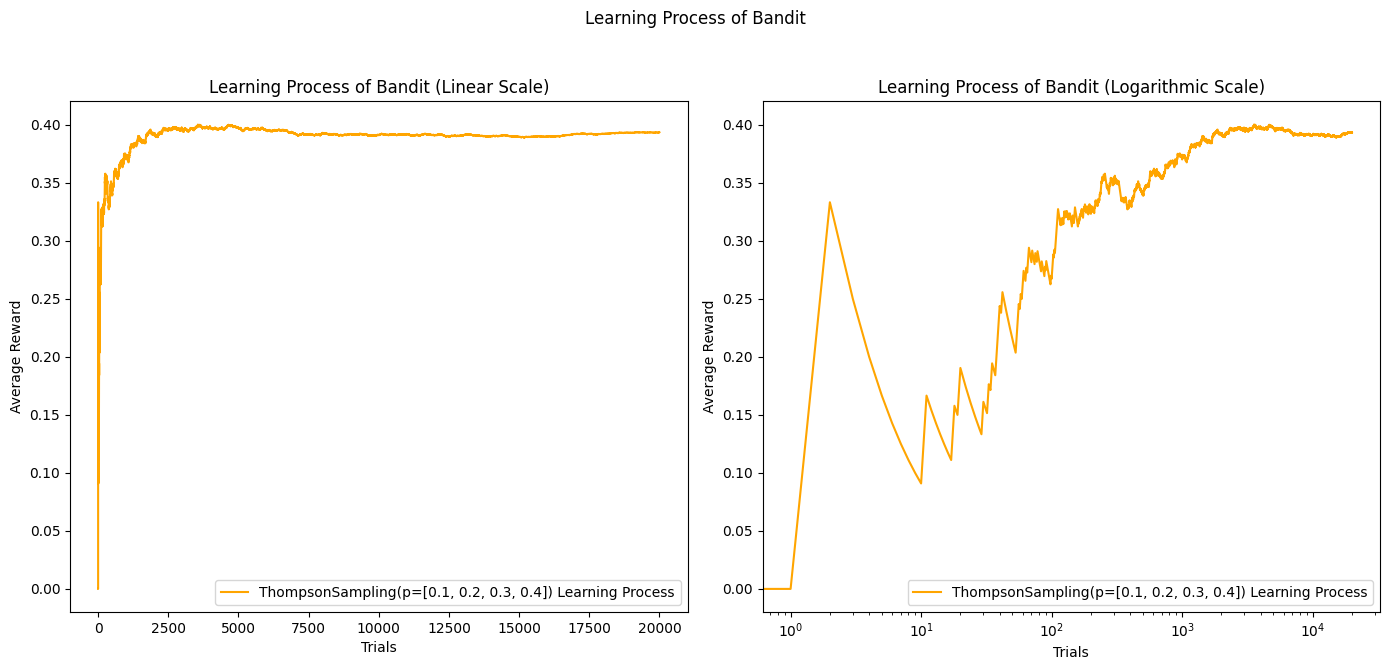

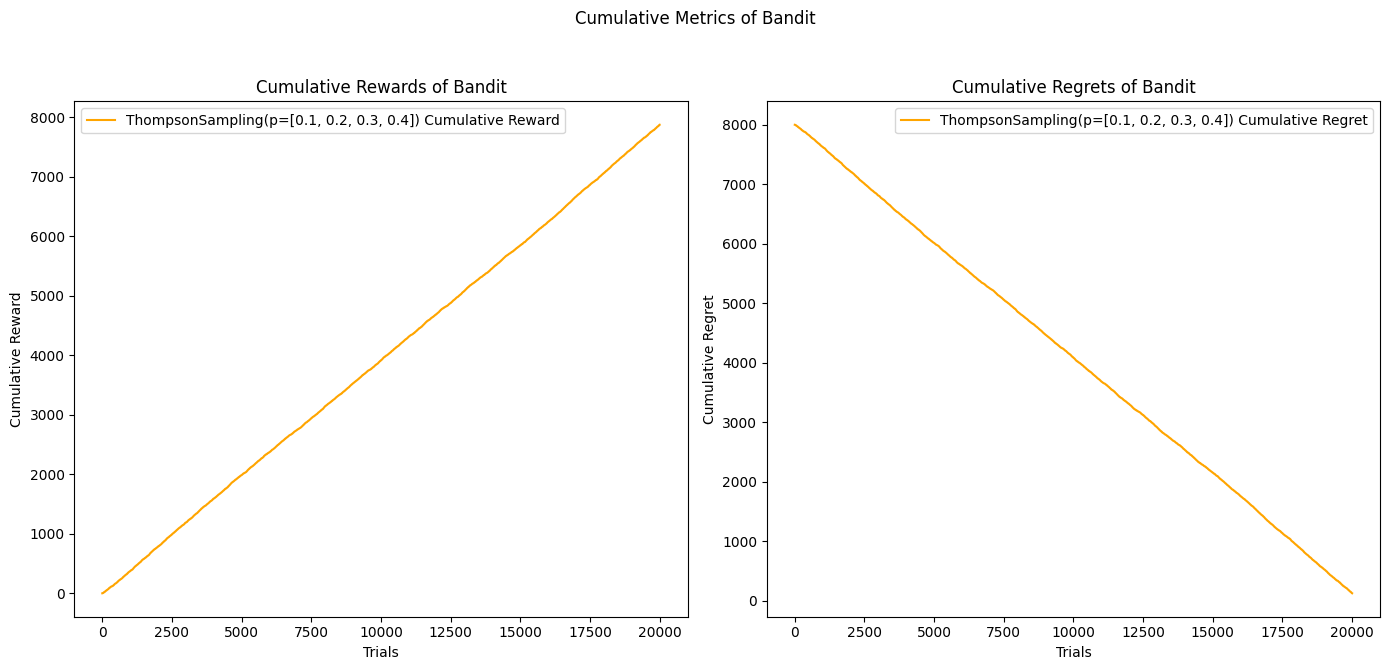

Cumulative Reward for EpsilonGreedy: 7961
Cumulative Regret for EpsilonGreedy: 39.0
Cumulative Reward for ThompsonSampling: 7873
Cumulative Regret for ThompsonSampling: 127.0


In [65]:
if __name__ == '__main__':
    bandit_probs = [0.1, 0.2, 0.3, 0.4]  # Probabilities of reward for each arm
    num_trials = 20000

    eg_bandit = EpsilonGreedy(bandit_probs)
    ts_bandit = ThompsonSampling(bandit_probs)

    eg_bandit.experiment(num_trials)
    ts_bandit.experiment(num_trials)

    viz = Visualization()
    print("Epsilon Greedy Results:")
    viz.plot1(eg_bandit, color='blue')
    viz.plot2(eg_bandit, color='blue')

    print("Thompson Sampling Results:")
    viz.plot1(ts_bandit, color='orange')
    viz.plot2(ts_bandit, color='orange')

    df_eg = eg_bandit.report()
    df_ts = ts_bandit.report()


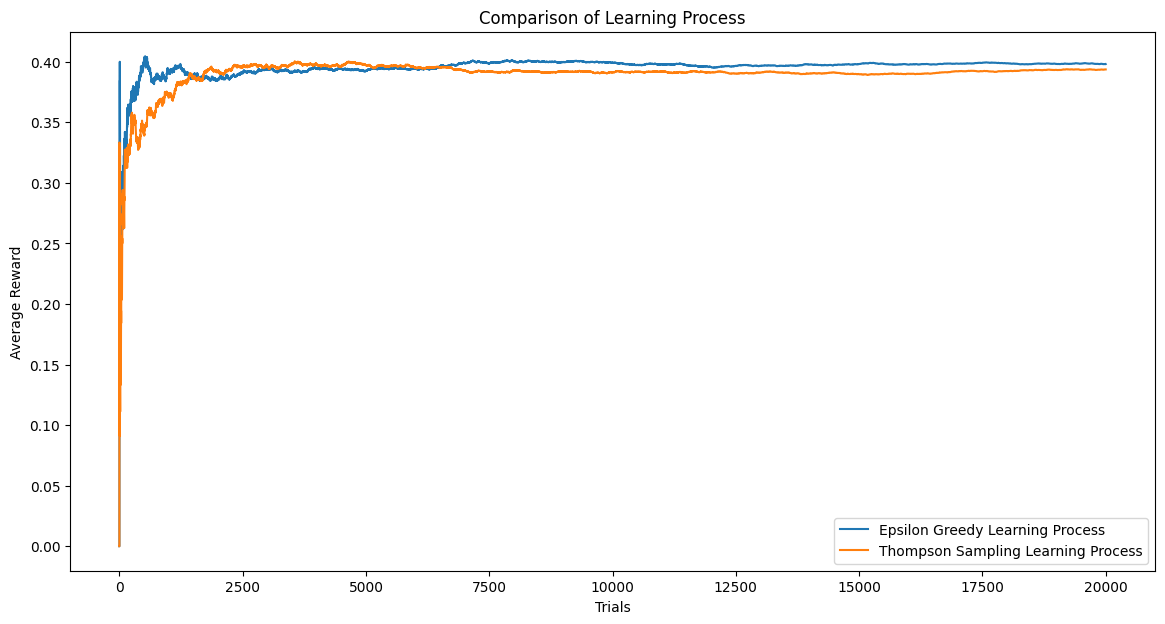

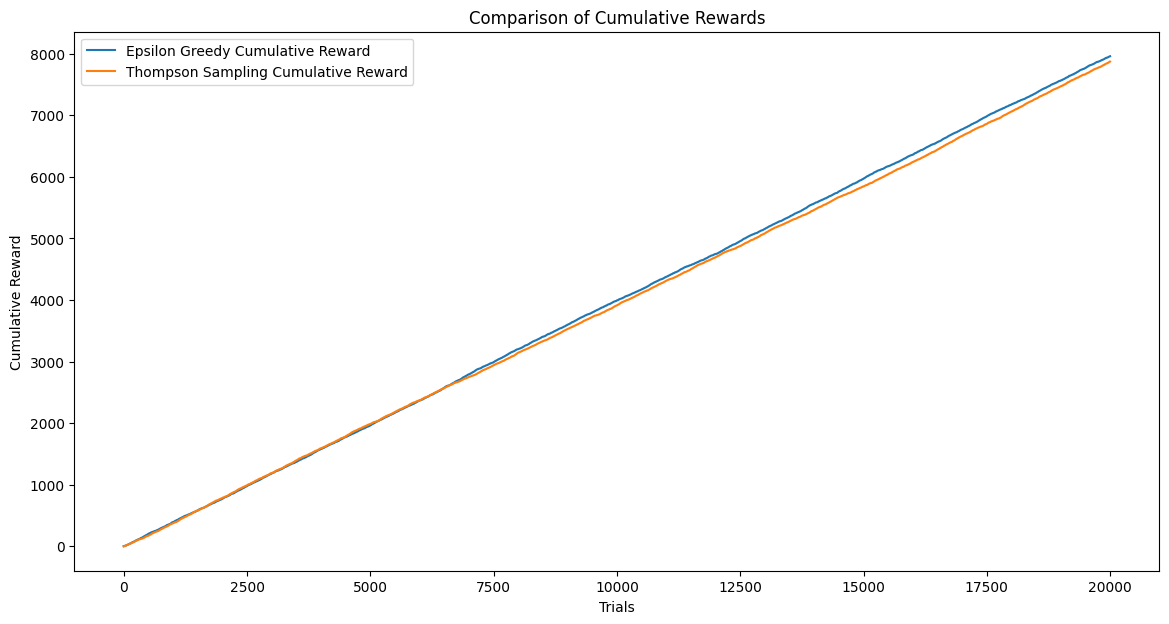

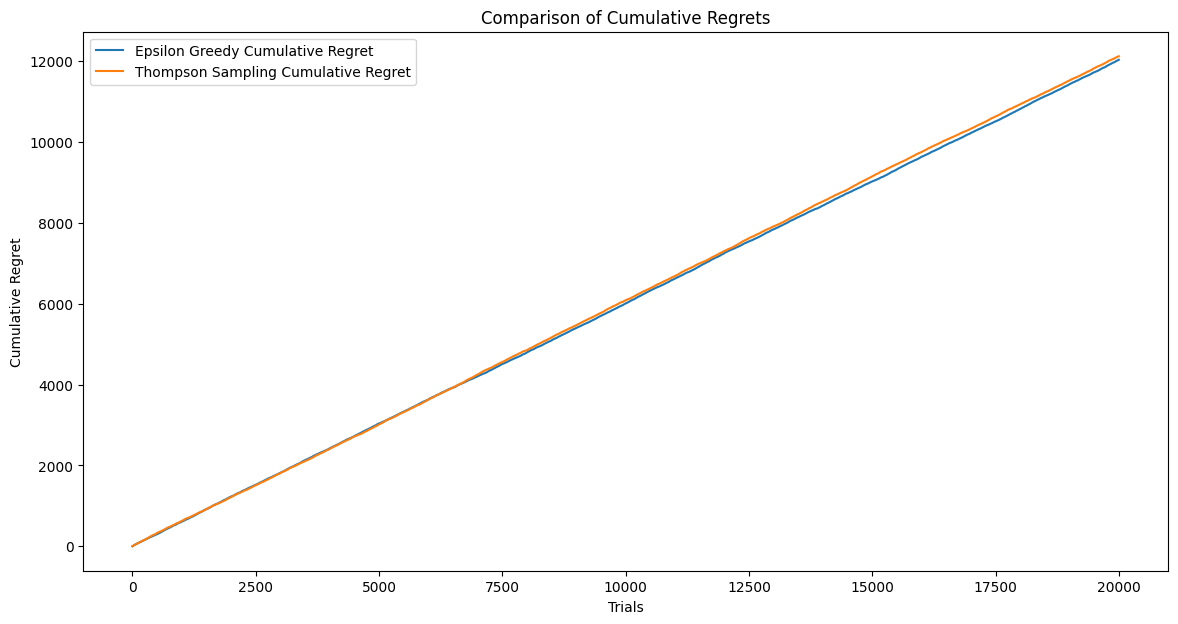

In [66]:
comparison(eg_bandit, ts_bandit)